In [4]:
import torch
import numpy as np
from scipy.special import logsumexp
data = np.load('../data/cifar10_1k.npz')
images = data['images']
labels = data['labels']

In [5]:
def vp_weights(timesteps):
    """
    Get the weights for the VP SDE
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    betas = np.linspace(beta_start, beta_end, timesteps)
    alphas = 1.0 - betas
    alphas_cumprod = np.cumprod(alphas)
    alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
    sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - alphas_cumprod)
    sigmas = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
    # log_sigmas = np.log(sigmas)

    return {
        'betas': betas,
        'alphas_cumprod': alphas_cumprod,
        'alphas_cumprod_prev': alphas_cumprod_prev,
        'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
        'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
        'sigmas': sigmas
    }
weights = vp_weights(1000)


In [6]:
data = np.load('../data/cifar10_1k.npz')
data['images'].shape

(1000, 3, 32, 32)

In [7]:
y = data['images']*weights['alphas_cumprod'][1]
sigma = weights['sqrt_one_minus_alphas_cumprod'][1]


In [8]:
weights['sqrt_one_minus_alphas_cumprod']

array([0.01      , 0.01482929, 0.01896621, 0.02279077, 0.02643872,
       0.02997442, 0.03343334, 0.03683694, 0.0401991 , 0.04352925,
       0.04683404, 0.05011833, 0.05338571, 0.05663894, 0.05988016,
       0.06311103, 0.0663329 , 0.06954683, 0.07275371, 0.07595425,
       0.07914905, 0.08233859, 0.08552328, 0.08870348, 0.09187947,
       0.0950515 , 0.09821976, 0.10138445, 0.1045457 , 0.10770364,
       0.11085838, 0.11401   , 0.11715857, 0.12030417, 0.12344683,
       0.12658661, 0.12972352, 0.13285761, 0.13598888, 0.13911734,
       0.14224302, 0.1453659 , 0.14848599, 0.15160328, 0.15471777,
       0.15782945, 0.16093829, 0.16404429, 0.16714743, 0.17024769,
       0.17334505, 0.17643948, 0.17953096, 0.18261947, 0.18570498,
       0.18878745, 0.19186687, 0.1949432 , 0.19801641, 0.20108648,
       0.20415336, 0.20721703, 0.21027745, 0.2133346 , 0.21638843,
       0.21943891, 0.22248602, 0.22552971, 0.22856994, 0.23160669,
       0.23463992, 0.23766959, 0.24069567, 0.24371812, 0.24673

In [9]:
random_image = data['images'][0:2] 

In [10]:
random_image = random_image[:, np.newaxis]
random_image.shape

(2, 1, 3, 32, 32)

sum 

In [13]:
logp = -(random_image - y)**2 / (2 * sigma**2) - np.log((np.sqrt(2 * np.pi * sigma**2)))
print(logp.min(), logp.max())
logp = np.sum(logp, axis=(2, 3, 4))
# p = np.exp(logp)
print(logp)
# print(p)
print(logp.shape)

# np.prod(p, axis=(2, 3, 4))
log_sum_of_probs = logsumexp(logp, axis=1, keepdims=True)
print(log_sum_of_probs.shape)
log_weights = logp - log_sum_of_probs

#shaped [2, 1000]
weights = np.exp(log_weights)
print(weights.shape)
# np.exp(log_sum_of_probs)

-9089.423212610216 3.2922122694193607
[[   10113.59602846 -2907922.03432286 -1669631.52911135 ...
  -4983558.85430324 -1276159.61592203 -6869677.2632507 ]
 [-2907661.54318798    10113.62467364 -2184109.57926943 ...
  -2745980.25801114 -3706752.28994271 -3267898.4721644 ]]
(2, 1000)
(2, 1)
(2, 1000)


In [210]:
grad = -(random_image-y) / (sigma**2)
weights = weights[:,:, np.newaxis, np.newaxis, np.newaxis] * grad
scores = np.sum(grad * weights, axis=1)
print(scores.shape)

(2, 3, 32, 32)


In [212]:
random_image.shape

(2, 1, 3, 32, 32)

In [190]:
log_likelihood = -np.random.rand(2, 1000) * 500000
# 手动设置一个“最可能”的匹配，使其值相对较大（没那么负）
log_likelihood[0, 100] = -250.0
log_likelihood[1, 200] = -300.0


# --- 计算 p 的总和 ---

# 目标：对于第一张图片，计算 p_0 + p_1 + ... + p_999
#       对于第二张图片，计算 p_0 + p_1 + ... + p_999

# 使用 logsumexp 沿 axis=1（样本维度）进行计算
# 它会返回一个包含2个元素的数组，每个元素是 sum(p) 的对数
log_sum_of_probs = logsumexp(log_likelihood, axis=1)


# 现在，log_sum_of_probs 里是 log(p_total)
# 为了得到最终的 p_total，我们只需要做一次 exp() 运算
total_probs = np.exp(log_sum_of_probs)
total_probs

array([2.66919022e-109, 5.14820022e-131])

In [161]:
prob = np.log(np.exp(-(random_image - y)**2 / (2 * sigma**2))/ (np.sqrt(2 * np.pi * sigma**2)))
prob_prod = np.sum(prob, axis=(1, 2, 3, 4))
print(np.log(prob_prod).shape)
print(np.log(prob_prod))

(2,)
[nan nan]


/tmp/ipykernel_797653/1172818928.py:1: RuntimeWarning: divide by zero encountered in log
  prob = np.log(np.exp(-(random_image - y)**2 / (2 * sigma**2))/ (np.sqrt(2 * np.pi * sigma**2)))
/tmp/ipykernel_797653/1172818928.py:3: RuntimeWarning: invalid value encountered in log
  print(np.log(prob_prod).shape)
/tmp/ipykernel_797653/1172818928.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(prob_prod))


gradients

In [ ]:
p = np.exp(-(random_image - y)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi * sigma**2))
exp_p = np.sum(p, axis=(1))
exp_p.shape

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.utils import Namespace, set_weights

from src.score_solution import reverse_sde
args = Namespace(
    sde_version='vp',
    device=0,
    timesteps=1000,
    start='noise',
    batchsize=8)
weights = set_weights(args)
sde = reverse_sde(args, weights)

Using device: cuda:0


In [2]:
images = sde.p_sample_loop(return_all_time_steps=True)

sampling loop time step:   3%|▎         | 28/1000 [00:00<00:08, 114.42it/s]

t=999, tensor([ 85, 451, 976, 505, 518, 798, 284, 749], device='cuda:0')
t=950, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')


sampling loop time step:  13%|█▎        | 133/1000 [00:00<00:03, 230.64it/s]

t=900, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')
t=850, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')


sampling loop time step:  24%|██▍       | 238/1000 [00:01<00:03, 251.96it/s]

t=800, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')
t=750, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')


sampling loop time step:  34%|███▍      | 345/1000 [00:01<00:02, 260.35it/s]

t=700, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')
t=650, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')


sampling loop time step:  43%|████▎     | 426/1000 [00:01<00:02, 257.18it/s]

t=600, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')
t=550, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')


sampling loop time step:  53%|█████▎    | 530/1000 [00:02<00:01, 255.07it/s]

t=500, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')
t=450, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')


sampling loop time step:  64%|██████▎   | 635/1000 [00:02<00:01, 255.81it/s]

t=400, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')
t=350, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')


sampling loop time step:  74%|███████▍  | 739/1000 [00:03<00:01, 254.48it/s]

t=300, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')
t=250, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')


sampling loop time step:  84%|████████▍ | 844/1000 [00:03<00:00, 254.97it/s]

t=200, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')
t=150, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')


sampling loop time step:  95%|█████████▍| 948/1000 [00:03<00:00, 256.15it/s]

t=100, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')
t=50, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')


sampling loop time step: 100%|██████████| 1000/1000 [00:04<00:00, 243.98it/s]

t=0, tensor([347, 347, 347, 347, 347, 347, 347, 347], device='cuda:0')


In [1]:
import numpy as np
def normalize(imgs):
    """
    Normalize the images to the range [0, 1]
    """
    imgs = imgs.cpu().detach().numpy()
    imgs =  (imgs+1)*0.5
    imgs = np.clip(imgs, 0, 1)
    return imgs

def show_images(images):
    """
    Show images in a grid，行列转置
    """
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(args.batchsize, 10, figsize=(10, 5)) 
    for i in range(10):
        index = max(0, i*100-1)
        imgs = normalize(images[index])
        for j in range(args.batchsize):
            ax = axes[j, i]  # 行列转置
            ax.imshow(imgs[j].transpose(1, 2, 0))
            ax.axis('off')
            if j == 0:
                ax.set_title(f"t = {index}", fontsize=10)
    
    plt.subplots_adjust(wspace=0.2)
    plt.show()
show_images(images)


NameError: name 'images' is not defined

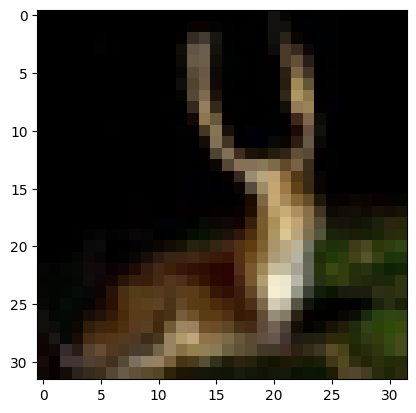

In [5]:
import matplotlib.pyplot as plt

# 假设你的 sde 实例已经创建
problem_image = (sde.images[347].cpu().numpy() + 1)*0.5
plt.imshow(problem_image.transpose(1, 2, 0)) # 假设图片是 CHW 格式
plt.show()

Using device: cuda:4


sampling loop time step:   6%|▌         | 60/1000 [00:00<00:03, 270.46it/s]

t=999, tensor([722, 137, 329, 915, 387, 244, 172, 654], device='cuda:4')
t=950, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')
t=900, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')


sampling loop time step:  25%|██▍       | 247/1000 [00:00<00:01, 535.02it/s]

t=850, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')
t=800, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')
t=750, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')


sampling loop time step:  38%|███▊      | 377/1000 [00:00<00:01, 590.65it/s]

t=700, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')
t=650, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')
t=600, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')


sampling loop time step:  57%|█████▋    | 566/1000 [00:01<00:00, 609.40it/s]

t=550, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')
t=500, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')
t=450, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')


sampling loop time step:  70%|██████▉   | 698/1000 [00:01<00:00, 632.45it/s]

t=400, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')
t=350, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')
t=300, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')


sampling loop time step:  83%|████████▎ | 828/1000 [00:01<00:00, 640.23it/s]

t=250, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')
t=200, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')
t=150, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')


sampling loop time step: 100%|██████████| 1000/1000 [00:01<00:00, 567.99it/s]


t=100, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')
t=50, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')
t=0, tensor([455, 347, 347, 347, 455, 347, 455, 347], device='cuda:4')


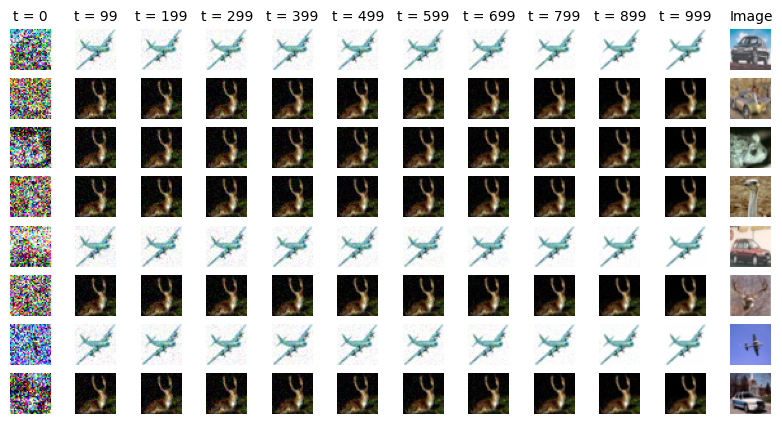

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.utils import Namespace, set_weights

from src.score_solution import reverse_sde
args = Namespace(
    sde_version='vp',
    device=4,
    timesteps=1000,
    start='sub_noise',
    batchsize=8)
weights = set_weights(args)
sde = reverse_sde(args, weights)

import numpy as np
def normalize(imgs):
    """
    Normalize the images to the range [0, 1]
    """
    imgs = imgs.cpu().detach().numpy()
    imgs =  (imgs+1)*0.5
    imgs = np.clip(imgs, 0, 1)
    return imgs

def show_images(images, args):
    """
    Show images in a grid，行列转置
    """
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(args.batchsize, 12, figsize=(10, 5)) 
    for i in range(11):
        index = max(0, i*100-1)
        imgs = normalize(images[index])
        for j in range(args.batchsize):
            ax = axes[j, i]  # 行列转置
            ax.imshow(imgs[j].transpose(1, 2, 0))
            ax.axis('off')
            if j == 0:
                ax.set_title(f"t = {index}", fontsize=10)
    
    if args.start == 'sub_noise':
        # 显示原始图像
        original_imgs = normalize(sde.sample)
        for j in range(args.batchsize):
            ax = axes[j, 11]
            ax.imshow(original_imgs[j].transpose(1, 2, 0))
            ax.axis('off')
            if j == 0:
                ax.set_title("Image", fontsize=10)
    plt.subplots_adjust(wspace=0.2)
    plt.show()
    
images = sde.p_sample_loop(return_all_time_steps=True)
show_images(images, args)